# Natural Dipole Analysis

This notebook discusses Python code to analyse Natural dipole moment of planar molecules. In the "*DIPOLE MOMENT ANALYSIS*" section, the NBO output file (.nbo, .out) contains individual x,y,z-components and length of the total molecular dipole moment. Each of the entries is decomposed into individual NLMO and NBO bond contributions. On the example of formamide, we are going to extract those lines and build a vector (NLMO) representation of the total molecular dipole.

Similar method using Java-based KNIME platform is described [here](http://bit.ly/1GzVcFV).


Details of the formamide analysis can be found in the excellent book of Weinhold and Landis:
Weinhold, F. and Landis, C.R. in [Discovering Chemistry with Natural Bond Orbitals](http://www.amazon.com/Discovering-Chemistry-With-Natural-Orbitals/dp/1118119967), pp. 147-152. 

![Formamide](./img/form.png) <span style="color:blue; margin-left: 290px">Planar geometry of formamide</span>

## Electric Dipole ##  
Electric dipole moment is the most fundamental quantity related to the charge distribution in a molecule. It reflects the degree to which positive and negative charge is distributed relative to one another. Dipole moment is a vector quantity characterized by its scalar magnitude, sign, and direction. Accordingly, the dipole can be described by its vector **μ** directed from the negative to the positive charge. Magnitude of the dipole moment is defined as: $$\mu = |q|*R,$$ where **q** is charge and **R** is the displacement vector pointing from the **negative** to **positive** charge. The net dipole moment of a molecule can be conceptually described as a vector sum of the individual moments.<br>
This is what we will attempt to do in the following cells.

### Styling and Imports ###
First the custom styling. File `*.css` inserts contents of custom .css file into the 
header of the notebook's HTML file. Other variants of .css files are in the ./css directory and differ only in color decoration of iPython notebook cells. This step is optional and the `if ... else` statement can be commented out.

In [1]:
%%capture
# suppress output; remove %% capture for debugging
# to (de)activate line numbering pres Esc while in the cell 
# followed by l (lower L)

'''Sanity check since we are changing directories and *.css file path
would be incorrect after cell re-run'''
from IPython.core.display import HTML
import string,sys,os,os.path,re
css_file = './css/blog.css'
if os.path.isfile(css_file):
    css_file
else:
    %cd ..
HTML(open(css_file, "r").read())

In [2]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from pylab import *
%matplotlib inline

# Pandas options
pd.set_option('display.max_columns', 14)
pd.set_option('display.width', 300)
#pd.set_option('display.mpl_style', 'default')  # enable for nicer plots
pd.set_option("max_columns", 14)
pd.set_option('chained_assignment',None)  # suppress warnings for web publishing

# Global parameters
rcParams['figure.figsize'] = (6, 6)

### csv to Dataframe ###
In the next step, coordinates of NLMO dipoles are read from *.csv file. This file was generated earlier using the KNIME "Dipole_v2/3" [workflow](http://bit.ly/1GzVcFV). Alternatively, iPython notebook <span style="color:rgba(255,100,0,1)">ReadNboDip.ipynb</span> at this [Github repository](http://bit.ly/1ztVa1C) creates the identical input file. "Plain" Python script (<span style="color:rgba(255,100,0,1)">ReadNboDip.py</span>) that parses NBO output files for the same <i>Dipole moment summary</i> can be downloaded from [this Github repository](http://bit.ly/142ZKWZ). 

In this example, this file is available from the ./dipole directory.<br>  

In [3]:
%%capture
# Step into the directory of input .csv files using the magic %cd
# Make sure that we are not already in the 'dipoles' dir from the previous run
if os.path.isdir('dipoles'):
    %cd dipoles
else:
    %cd ..
    %cd dipoles

First, a row of arbitrary values (zeroes) is inserted at the top of dataframe **df** (line 15; press Esc+l (lower L)) and the table values are assigned int, float, or string types, respectively.

In [4]:
# Input file can be generated in ReadNboDip.ipynb notebook
infile = 'form_dip.csv'  # in directory ./dipoles
# Save the file path, name and extension
fullpath =  os.path.abspath(infile)
path,file=os.path.split(fullpath)
basename, extension = os.path.splitext(infile)

# Create Pandas dataframe from the *.csv file
df = pd.read_csv(infile)
# fix datatype for columns
df.convert_objects(convert_numeric=True).dtypes 

# Prepare first blank row with XYZ=0 to set the point of vector origin
# set the first row to zeroes
rowex = df.loc[[0]] 
# Get dataframe column headers
headers = df.columns.values.tolist()
# Fix the data types
for item in headers:
    if df.dtypes[item] == 'float64' :
        rowex[item] = 0.
    elif df.dtypes[item] == 'int64' :
        rowex[item] = 0
    else :
        rowex[item] = ''
row0 = rowex

In [5]:
# Reassemble data table placing row0 at the top, followed by the rest
df2 = pd.concat([row0, df]).reset_index().ix[::]
# print df2

In [6]:
""" Identify which column (coordinate) has constant values (orthogonal to the 
molecular plane).
"""
# Prepare stds of absolute values for each x,y,z column
# Smallest stds indicate constant dimension perpendicular to 2D plane
C1 = df2["X"].abs()
C1std = C1.std()
C2 = df2["Y"].abs()
C2std = C2.std()
C3 = df2["Z"].abs()
C3std = C3.std()
# print "stds are: %.3f %.3f %.3f" % (C1std, C2std, C3std)

In [7]:
'''Assign X,Y coordinates only, Z=0. Any of the X,Y,Z can be constant or 
zero 0 (which one may change every time). 
Remap coordinates arbitrarily to X,Y with Z=[const] '''
def coord_headers(C1std, C2std, C3std):
    if C1std > 0.1 and C2std > 0.1 > C3std:
        df2['newX'] = df2["X"]
        df2['newY'] = df2["Y"]
    elif C1std > 0.1 > C2std and C3std > 0.1:
        df2['newX'] = df2["X"]
        df2['newY'] = df2["Z"]
    elif C1std < 0.1 < C2std and C3std > 0.1:
        df2['newX'] = df2["Y"]
        df2['newY'] = df2["Z"]
    else:
        df2['newX'] = df2["X"]
        df2['newY'] = df2["Y"]

In [8]:
# Append columns newX,newY to df2 (values are often same as the original X,Y)
# Plane defined
coord_headers(C1std, C2std, C3std)

# Remove rows with CR (core) orbitals and reindex the dataframe
df2 = df2[~df2['Type'].str.contains("CR")]

# Copy dataframe for the intermediate output
df2b1 = df2.reset_index().ix[::] # Comment off if re-running the cell

HTML(df2b1.to_html(classes = 'grid', escape=False))
# table styling requires package qgrid http://nbviewer.ipython.org/github/quantopian/qgrid/
# blob/master/qgrid_demo.ipynb

,level_0,index,NLMO,Type,X,Y,Z,Tot_Dip,newX,newY
0,0,0,0,,0.00,0,0.00,0.00,0.00,0.00
1,4,3,4,LP ( 1) N 1,-0.20,0,-1.64,1.65,-0.20,-1.64
2,5,4,5,LP ( 1) O 3,-2.37,0,-1.64,2.88,-2.37,-1.64
3,6,5,6,LP ( 2) O 3,0.89,0,0.75,1.16,0.89,0.75
4,7,6,7,BD ( 1) N 1- C 2,0.02,0,0.85,0.85,0.02,0.85
5,8,7,8,BD ( 1) N 1- H 4,-0.68,0,0.47,0.82,-0.68,0.47
6,9,8,9,BD ( 1) N 1- H 5,0.75,0,0.46,0.88,0.75,0.46
7,10,9,10,BD ( 1) C 2- O 3,-1.90,0,-1.44,2.38,-1.90,-1.44
8,11,10,11,BD ( 2) C 2- O 3,-0.67,0,-0.46,0.81,-0.67,-0.46
9,12,11,12,BD ( 1) C 2- H 6,1.72,0,-0.58,1.82,1.72,-0.58


<center><span style="color: orange"><b>Table 1</b>.  Current df2 with new columns for consolidated X, Y coordinates.</span></center>

----------
### First Plot###
Now, to have dipole vectors continue from one to another (as opposed to all starting at the zero), we have to <em>transpose coordinates</em> in a way that the origin of new vector starts at the end of the previous vector. In Python, use the function `cumsum()`.
Let's try to build continuous vector graph from the original dataframe **df2**. This is equivalent to a vector decomposition.

<span style="color:rgba(217,0,126,1)">**The following cell is just a test case**</span> (can be removed later). It generates plot of <span style="color: orange"><b>Table 1</b></span> as continuing vector segments. You can [skip it and go to section "Cleaning up the Vector Path"](#Cleaning-up-the-Vector-Path).

C:\Anaconda\envs\notebook\lib\site-packages\matplotlib\text.py:1857: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


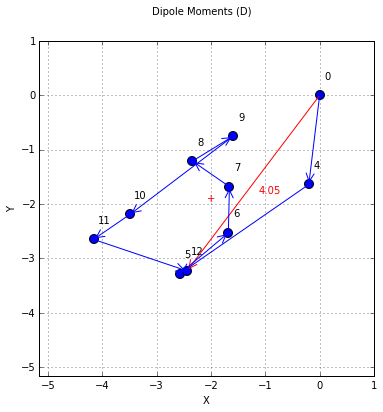

In [9]:
# Test area running off the branch df2b1
# Translate coordinates from X,Y,Z=0,0,0 to assure vector continuity
df2b1['newXa'] = df2b1.newX.cumsum()
df2b1['newYa'] = df2b1.newY.cumsum()
df3b = df2b1
# print df3b

# Calculate total dipole (compare with column Tot_Dip)
lastX = df3b.tail(1).newXa  # row and value
lastX = lastX.tolist()[0]  # value only
lastY = df3b.tail(1).newYa
lastY = lastY.tolist()[0]
total_dipole = sqrt(np.power(lastX, 2)+np.power(lastY, 2))
total_dipole = round(total_dipole, 2)

# Calc geometrical center of the vector polygon
cenX = df3b['newXa'].mean()
cenY = df3b['newYa'].mean()
x = df3b.newXa
y = df3b.newYa

# Plot
# Set rectangular plot dimensions to keep lengths proportional
xlow = x.min()
xhigh = x.max()
ylow = y.min()
yhigh = y.max()


def lst_sort(list):
    ''' 
    Sort list of floats by values.
    
    :type list: list of floats
    :param list: max and min x,y-coordinates
  
    :rtype: list of floats
    :return: sorted list of floats    
    '''   
    abslist = []
    for item in list:
        abslist.append(item)
    return sorted(abslist)

margins = lst_sort([xlow, ylow, xhigh, yhigh])

plt.figure()  # To generate multiple distinct plots.
plt.suptitle('Dipole Moments (D)')
ax = []
xmin = margins[0]-1 #x.min()-1
xmax = margins[3]+1
ymin = margins[0]-1
ymax = margins[3]+1
plt.ylabel('Y')
plt.xlabel('X')
plt.grid(True)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
color='blue'
plt.scatter(df3b.newXa, df3b.newYa, s=80, c=color, label='NLMOs')
for j, txt in enumerate(df3b['NLMO']):
    plt.annotate(txt, (x[j]+0.1,y[j]+0.3))
ax = gca()
ax.add_patch(FancyArrowPatch((0,0),(lastX,lastY),arrowstyle='->',mutation_scale=20, color='red'))
for k in range(1,len(x)):
    ax.add_patch(FancyArrowPatch((x[k], y[k]),(x[k-1],y[k-1]),arrowstyle='<-',mutation_scale=20, color='blue'))

plt.annotate(total_dipole,
             xy=(lastX/2*0.9, lastY/2*1.1),
             color='red',
             xycoords='data',
             textcoords='offset points')


plt.annotate("+",
             xy=(cenX, cenY),
             color='red',
             xycoords='data',
             textcoords='offset points')

### Cleaning up the Vector Path###
Resulting plot is rather cluttered and thus we will need to arrange dipoles in some way to get a more interpretable view.
Since most molecules have center of the coordinate system placed somewhere at the center of the molecule, sorting dipole coordinates by xy-quadrant in which the dipole origin resides is a sensible approach. The following cartoon indicates how such quadrants are defined.
![Qadrants](./img/quadrants.png "Quadrant definition")
We will write a function that assigns each row an arbitrary quadrant depending on the signs of coordinates **x** and **y**. To further arrange directions of lines in each quadrant, we will include another function that calculates **slope** of the line and we will sort by the **quadrant** (rank) and the **slope**.
____

In [10]:
# Function to rank XY-points into quadrants 0-3
def xyrank(a, b, c, d, e, f):
    ''' 
    Assign qudrant value 1,2,3,4.
    :type inputs: floats and str
    :param inputs: X, Y, Q(1), Q(2), Q(3), Q(4)  
    :rtype: str
    :return: quadrant number as str    
    '''
    if a > 0 and b > 0:  # [Q1]
        return c
    elif a > 0 > b:  # [Q2]
        return d
    elif a < 0 and b < 0:  # [Q3]
        return e
    else:  # [Q4] 1 a>0, b<0
        return f
        
        
# Function to calculate slope
def slope(a, b):
    if a != 0:
        slope = (1.0 * b / a)  # expects float
        return slope
    else:
        slope = 0  # for a = zero, set slope arbitrarily to 0
        return slope

Unfortunately, it is not obvious which sequence of quadrants will lead to the least cluttered dipole diagram. To make sure that we test all possibilities, we will evaluate all permutations of four quadrants, that is, 4! = 4 x 3 x 2 x 1  = 24

For each trial, we record an array of quadrants and standard deviation of distances of all vector origins from the graph origin (geometric center). Small stds should indicate even distribution of vectors around the origin (circle, ellipsoid, symmetrical polygon?). Standard deviation of distances together with the sequence of quadrants appear at the top of each plot. As we will see later, lowest stds are not necesarilly indicative of the "clean" graph shape.

<span style="color:rgba(190,0,0,0.8)"> <u>By no means the resulting vector plots indicate atom connectivity!</u></span> It is the relative direction of dipole vectors that helps us to assess the importance and internal balance of NLMO orbitals within the molecule. 

In [11]:
# Get the list of quadrant permutations
# Four quadrants of a XY plot
lst = [0, 1, 2, 3]
set(list(lst))  # Creates a set
import itertools
permlist = set(itertools.permutations(lst))
permlist = list(permlist)  # Get permutation set into a list.

### Plot Survey###
For each set of qudrants, the code below will sort the dataframe by the quadrant and slope. The corresponding plot will be created and saved as .png image. Quadrant sequence is part of the filename.

In [12]:
%%capture
# remove %%capture magic to see the plot and output

# Iterate through the list of all quadrants
global captarr
captarr = []
captperm = []
for i in range(len(permlist)):
    # Apply function to the table values in each row; make a copy first
    df21 = df2.copy()
    df21["xyRank"] = df2.apply(
        lambda row: xyrank(row['newX'], row['newY'], permlist[i][0], 
                           permlist[i][1], permlist[i][2], permlist[i][3]),
        axis=1)

    # Apply function to table values in a row
    df21["slope"] = df21.apply(lambda row: slope(row['newX'], row['newY']), axis=1)
    
    toprow = df21[:1]  # row with zero dipole 
    # Directly change rank of the first row in the dataframe
    toprow.xyRank[0] = 4
    # Isolate remaining data into rest (drop)
    rest1 = df21.drop(df21.index[[0, 0]])
    # sort rest1 by xyRank, then by slope - descending
    df3 = rest1.sort_index(by=['xyRank', 'slope'], ascending=[False, False])
    # Put it back
    df3 = pd.concat([toprow, df3]).reset_index().ix[::]
    df3 = df3.sort_index(by=['xyRank', 'slope'], ascending=[False, False])

    # Translate coordinates from xyz=0,0,0
    df3['newXa'] = df3.newX.cumsum()
    df3['newYa'] = df3.newY.cumsum()

    # Calculate total dipole
    lastX = df3.tail(1).newXa  # row and value
    lastX = lastX.tolist()[0]  # value only
    lastY = df3.tail(1).newYa
    lastY = lastY.tolist()[0]
    total_dipole = sqrt(np.power(lastX, 2) + np.power(lastY, 2))
    total_dipole = round(total_dipole, 2)

    # Calc distances of x,y and assess even distribution of points 
    # around the geom center
    cenX = df3['newXa'].mean()
    cenY = df3['newYa'].mean()
    distX = abs(cenX - df3.newXa)
    distY = abs(cenY - df3.newYa)
    # distance from centroid
    distXY = np.sqrt(distX * distX + distY * distY)
    diststd = distXY.std()
    captarr.append(round(diststd, 1))
    captperm.append(permlist[i])
    print "++++++++++ Rank list is : ", permlist[i], "; \
                std of distances is:", round(diststd, 2)

    # Plot
    plt.figure()  # To generate multiple distinct plots.
    plt.suptitle('Dipole Moments (D)')
    ax = []
    x = df3.newXa
    y = df3.newYa
    xmin = x.min() - 1
    xmax = x.max() + 1
    ymin = y.min() - 1
    ymax = y.max() + 1
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.grid(True)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    color = 'blue'
    plt.scatter(df3.newXa, df3.newYa, s=80, c=color, label='NLMOs')
    # plt.plot(df3.newXa, df3.newYa, c=color)
    # plt.legend(loc=1,borderaxespad=0.)
    for j, txt in enumerate(df3['NLMO']):
        plt.annotate(txt, (x[j] + 0.1, y[j] + 0.3))
    ax = gca()
    ax.add_patch(FancyArrowPatch((0, 0), (lastX, lastY), arrowstyle='->', \
                                 mutation_scale=20, color='red'))
    for k in range(1, len(x)):
        ax.add_patch(
            FancyArrowPatch((x[k], y[k]), (x[k - 1], y[k - 1]), arrowstyle='<-', \
                            mutation_scale=20, color='blue'))

    plt.annotate(total_dipole,
                 xy=(lastX / 2 * 0.9, lastY / 2 * 1.1),
                 color='red',
                 xycoords='data',
                 textcoords='offset points')

    plt.annotate(round(diststd, 2),
                 xy=(df3['newXa'].min() + 1.5, df3['newYa'].max() + 0.3),
                 color='green',
                 xycoords='data',
                 textcoords='offset points')

    plt.annotate((permlist[i]),  # asumX, asumY, 
                 xy=(xmin + 0.2, ymax - 0.7),
                 color='black',
                 xycoords='data',
                 textcoords='offset points')

    plt.annotate("+",
                 xy=(cenX, cenY),
                 color='red',
                 xycoords='data',
                 textcoords='offset points')

    # plt.show()
    f_perm = str(permlist[i]).replace("(", "_")
    f_perm = f_perm.replace(")", "_")
    f_perm = f_perm.replace(",","")
    f_perm = f_perm.replace(" ","")
    pic = basename  + f_perm + '.png'  
    try:
        plt.savefig(pic, ext='png', format='png', dpi=100)
    except IOError:
        print "Error: can\'t find the file or read data"

In [13]:
# %%capture
# remove %%capture magic to see output
# print "\n" +('-'*80)+"\n"
# print "> Images were saved in "+ path +"\\"+basename+"_q1q2q3q4_.png files"

In [14]:
# Sort by distance stds and retrieve the first three results
data = zip(captperm, captarr)
sor = sorted(data, key=lambda tup: tup[1])
print sor[0:3]

[((0, 2, 1, 3), 1.0), ((3, 0, 2, 1), 1.1), ((3, 1, 2, 0), 1.1)]


Inspect graphs above and note the quadrant sequence of the best looking graph. As indicated earlier, it is not the graph with lowest std value.

### Final Plot###
To make the final plot, enter the quadrant sequence of the best looking plot above (0,3,2,1) and replace the sequence in variable `quad`. The plot image will be saved in directory ./dipole.

**<span style="color:blue">Enter the quadrant sequence  (to line 2) and re-run the last part to get the graph.</span>**

,NLMO,Type,X,Y,Z,Tot_Dip,newX,newY,xyRank,slope,newXa,newYa
0,0,,0.00,0,0.00,0.00,0.00,0.00,4,0.000000,0.00,0.00
1,12,BD ( 1) C 2- H 6,1.72,0,-0.58,1.82,1.72,-0.58,3,-0.337209,1.72,-0.58
2,4,LP ( 1) N 1,-0.20,0,-1.64,1.65,-0.20,-1.64,2,8.200000,1.52,-2.22
3,10,BD ( 1) C 2- O 3,-1.90,0,-1.44,2.38,-1.90,-1.44,2,0.757895,-0.38,-3.66
4,5,LP ( 1) O 3,-2.37,0,-1.64,2.88,-2.37,-1.64,2,0.691983,-2.75,-5.30
5,11,BD ( 2) C 2- O 3,-0.67,0,-0.46,0.81,-0.67,-0.46,2,0.686567,-3.42,-5.76
6,8,BD ( 1) N 1- H 4,-0.68,0,0.47,0.82,-0.68,0.47,1,-0.691176,-4.10,-5.29
7,7,BD ( 1) N 1- C 2,0.02,0,0.85,0.85,0.02,0.85,0,42.500000,-4.08,-4.44
8,6,LP ( 2) O 3,0.89,0,0.75,1.16,0.89,0.75,0,0.842697,-3.19,-3.69
9,9,BD ( 1) N 1- H 5,0.75,0,0.46,0.88,0.75,0.46,0,0.613333,-2.44,-3.23


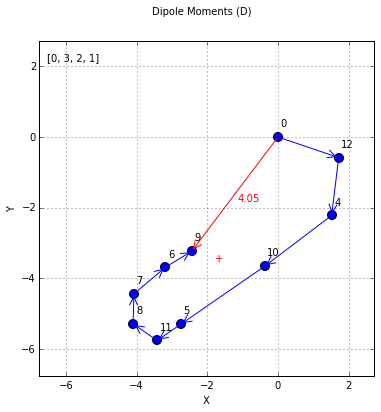

In [15]:
# Enter the best sequence of quadrants
quad = [0, 3, 2, 1] # original sequence 0,3,2,1 or 1,3,2,0
df21 = df2.copy()
df21["xyRank"] = df2.apply(lambda row: xyrank(row['newX'], row['newY'],\
                 quad[0], quad[1], quad[2], quad[3]), axis=1)

# Apply function to table values in a row
df21["slope"] = df21.apply(lambda row: slope(row['newX'], row['newY']), axis=1)
toprow = df21[:1]  # row with zero dipole 
# Directly change cell rank in dataframe
toprow.xyRank[0] = 4
# Isolate remaining data into rest (drop)
rest1 = df21.drop(df21.index[[0, 0]])
# sort rest1 by xyRank, then by slope - descending
df3 = rest1.sort_index(by=['xyRank', 'slope'], ascending=[False, False])
# Put it back
df3 = pd.concat([toprow,df3]).reset_index().ix[::]
df3 = df3.sort_index(by=['xyRank', 'slope'], ascending=[False, False])


# Translate coordinates from xyz=0,0,0
df3['newXa'] = df3.newX.cumsum()
df3['newYa'] = df3.newY.cumsum()
# print df3 # works OK

# Calculate total dipole
lastX = df3.tail(1).newXa  # row and value
lastX = lastX.tolist()[0]  # value only
lastY = df3.tail(1).newYa
lastY = lastY.tolist()[0]
total_dipole = sqrt(np.power(lastX, 2)+np.power(lastY, 2))
total_dipole = round(total_dipole, 2)

# Calc distances of x,y and assess fit to a circle
cenX = df3['newXa'].mean()
cenY = df3['newYa'].mean()
distX = abs(cenX-df3.newXa)
distY = abs(cenY-df3.newYa)
# distance from centroid
distXY = np.sqrt(distX*distX + distY*distY)
diststd = distXY.std()

x = df3.newXa
y = df3.newYa

# Set rectangular plot dimensions to keep lengths proportional
xlow = x.min()
xhigh = x.max()
ylow = y.min()
yhigh = y.max()


def lst_sort(list):
    ''' 
    Sort list of floats by values.
    
    :type list: list of floats
    :param list: max and min x,y-coordinates
  
    :rtype: list of floats
    :return: sorted list of floats    
    '''   
    abslist = []
    for item in list:
        abslist.append(item)
    return sorted(abslist)

margins = lst_sort([xlow, ylow, xhigh, yhigh])

# Plot
plt.figure()  # To generate multiple distinct plots.
plt.suptitle('Dipole Moments (D)')
ax = []
xmin = margins[0]-1
xmax = margins[3]+1
ymin = margins[0]-1
ymax = margins[3]+1
plt.ylabel('Y')
plt.xlabel('X')
plt.grid(True)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
color='blue'
plt.scatter(df3.newXa, df3.newYa, s=80, c=color, label='NLMOs')
# plt.plot(df3.newXa, df3.newYa, c=color)
# plt.legend(loc=1,borderaxespad=0.)
for j, txt in enumerate(df3['NLMO']):
    plt.annotate(txt, (x[j]+0.1,y[j]+0.3))
ax = gca()
ax.add_patch(FancyArrowPatch((0,0),(lastX,lastY),arrowstyle='->',mutation_scale=20, \
                             color='red'))
for k in range(1,len(x)):
    ax.add_patch(FancyArrowPatch((x[k], y[k]),(x[k-1],y[k-1]),arrowstyle='<-',\
                                 mutation_scale=20, color='blue'))

plt.annotate(total_dipole,
             xy=(lastX/2*0.9, lastY/2*1.1),
             color='red',
             xycoords='data',
             textcoords='offset points')


plt.annotate((quad),  # asumX, asumY, 
             xy=(xmin+0.4, ymax-0.6),
             color='black',
             xycoords='data',
             textcoords='offset points')

plt.annotate("+",
             xy=(cenX, cenY),
             color='red',
             xycoords='data',
             textcoords='offset points')

df3.drop('level_0', axis=1, inplace=True)
df3.drop('index', axis=1, inplace=True)
HTML(df3.to_html(classes = 'grid', escape=False))

Alternative and acceptable vector decomposition is shown in Figure 4.
![Figure 4](dipoles/form_dip_3210_.png)
<center><span style="color: orange"><b>Figure 4</b>.  Alternative vector decomposition.</span></center>

This concludes the analysis of NLMO dipole moment data from the NBO output file. Several vector paths composed of partial formamide dipoles were created and saved as images.
Next step will be analysis of partial NLMO dipoles in terms of bonds and lone pair contributions.

_____

<span style="font-size: 12px"><i>iPython Notebook **Dipoles_quad_all_Jupyter.ipynb**:<br>
version 1.0 created on Dec 23, 2014<br>
version 2.0 updated on Aug 29, 2015</i></span>